In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix

import torch.nn.functional as F

print("Current path:", os.getcwd())
if os.getcwd().endswith("notebooks"):
    os.chdir("..")
from src.models import naive_dec

plt.style.use('./notebooks/tutorial_style.txt')

print("Num Workers:", os.cpu_count())

Current path: /home/ubuntu/BrainDecoding
Num Workers: 32


In [30]:
experiment_dir = r"outputs/resnet_7sbjs_drop0.5_20250424"

In [31]:
train_raw = torch.load(os.path.join(experiment_dir, "train_outputs.pt"))
val_raw = torch.load(os.path.join(experiment_dir, "val_outputs.pt"))
test_raw = torch.load(os.path.join(experiment_dir, "test_outputs.pt"))

Train Accuracy: 1.0
Validation Accuracy: 0.5857142806053162
Test Accuracy: 0.532951295375824


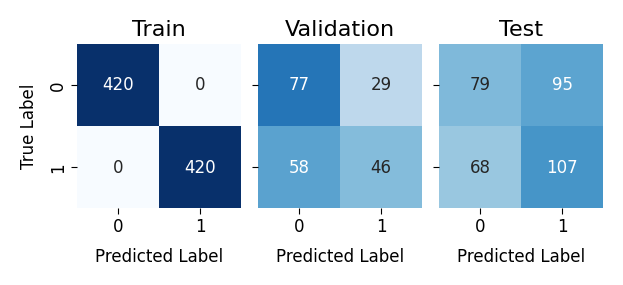

In [32]:
train_outputs, train_labels = train_raw["outputs"], train_raw["labels"]
train_pred_label = torch.argmax(train_outputs, dim=1)
outputs, labels, subjects = val_raw["outputs"], val_raw["labels"], val_raw["subjects"]
pred_label = torch.argmax(outputs, dim=1)
test_outputs, test_labels, test_subjects = test_raw["outputs"], test_raw["labels"], test_raw["subjects"]
test_pred_label = torch.argmax(test_outputs, dim=1)

cm_matrix_train = confusion_matrix(train_labels.cpu(), train_pred_label.cpu(), labels=[0, 1])
cm_matrix_val = confusion_matrix(labels.cpu(), pred_label.cpu(), labels=[0, 1])
cm_matrix_test = confusion_matrix(test_labels.cpu(), test_pred_label.cpu(), labels=[0, 1])

fig, ax = plt.subplots(1, 3, figsize=(3, 2), sharey=True)

sns.heatmap(cm_matrix_train, annot=True, fmt='d', cmap='Blues', ax=ax[0], square=True, cbar=False, vmin=0, vmax=len(train_labels)/2)
ax[0].set_title("Train")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")
ax[0].set_xticklabels([0, 1])
ax[0].set_yticklabels([0, 1])

sns.heatmap(cm_matrix_val, annot=True, fmt='d', cmap='Blues', ax=ax[1], square=True, cbar=False, vmin=0, vmax=len(labels)/2)
ax[1].set_title("Validation")
ax[1].set_xlabel("Predicted Label")
ax[1].set_xticklabels([0, 1])
ax[1].set_yticklabels([0, 1])

sns.heatmap(cm_matrix_test, annot=True, fmt='d', cmap='Blues', ax=ax[2], square=True, cbar=False, vmin=0, vmax=len(test_labels)/2)
ax[2].set_title("Test")
ax[2].set_xlabel("Predicted Label")
ax[2].set_xticklabels([0, 1])
ax[2].set_yticklabels([0, 1])

print("Train Accuracy:", (train_pred_label == train_labels).float().mean().item())
print("Validation Accuracy:", (pred_label == labels).float().mean().item())
print("Test Accuracy:", (test_pred_label == test_labels).float().mean().item())
plt.show()

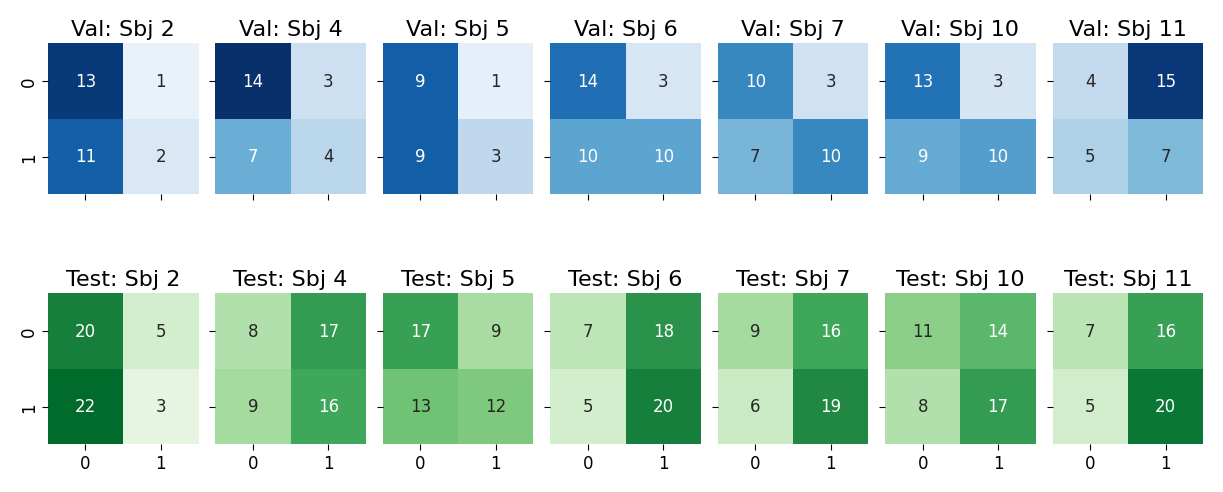

In [33]:
unique_subjects = torch.unique(subjects)

n_subjects = len(unique_subjects)


fig, axs = plt.subplots(2, n_subjects, figsize=(6, 2.5), sharex=True, sharey=True)
for idx, subject in enumerate(unique_subjects):
    subject_mask = (subjects == subject)

    # Training data
    subject_labels = labels[subject_mask]
    subject_preds = pred_label[subject_mask]
    cm_train = confusion_matrix(subject_labels.cpu(), subject_preds.cpu(), labels=[0, 1])

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axs[0, idx], square=True, cbar=False, vmin=0, vmax=len(subject_labels)/2)
    axs[0, idx].set_title(f"Val: Sbj {subject}")
    axs[0, idx].set_xticklabels([0, 1])
    axs[0, idx].set_yticklabels([0, 1])

    # Test data
    test_mask = (test_subjects == subject)
    test_subject_labels = test_labels[test_mask]
    test_subject_preds = test_pred_label[test_mask]
    cm_test = confusion_matrix(test_subject_labels.cpu(), test_subject_preds.cpu(), labels=[0, 1])

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axs[1, idx], square=True, cbar=False, vmin=0, vmax=len(test_subject_labels)/2)
    axs[1, idx].set_title(f"Test: Sbj {subject.item()}")
    axs[1, idx].set_xticklabels([0, 1])
    axs[1, idx].set_yticklabels([0, 1])

plt.show()

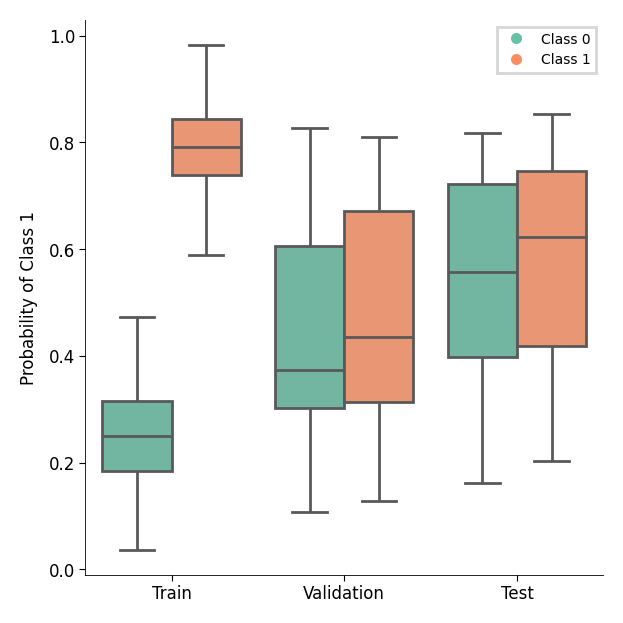

In [34]:
probs = torch.sigmoid(outputs)[:, 1]
probs_train = torch.sigmoid(train_outputs)[:, 1]
probs_test = torch.sigmoid(test_outputs)[:, 1]
fig, ax = plt.subplots(figsize=(3, 3))
#sns.stripplot(x=0, y=probs_train.detach(), hue=train_labels, ax=ax, alpha=0.5, jitter=0.3)
#sns.stripplot(x=1, y=probs, hue=labels, ax=ax, alpha=0.5, jitter=0.3)
#sns.stripplot(x=2, y=probs_test.detach(), hue=test_labels, ax=ax, alpha=0.5, jitter=0.3)
sns.boxplot(x=0, y=probs_train.detach(), hue=train_labels, ax=ax, dodge=True, palette="Set2", fliersize=0)
sns.boxplot(x=1, y=probs, hue=labels, ax=ax, dodge=True, palette="Set2", fliersize=0)
sns.boxplot(x=2, y=probs_test.detach(), hue=test_labels, ax=ax, dodge=True, palette="Set2", fliersize=0)
ax.set_xticks([0, 1, 2], ["Train", "Validation", "Test"])
ax.set_ylabel("Probability of Class 1")
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Class 0', markerfacecolor=sns.color_palette("Set2")[0], markersize=5),
    plt.Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor=sns.color_palette("Set2")[1], markersize=5)
]
ax.legend(handles=handles, loc='upper right')
plt.show()

In [35]:
# Load montage
loc = np.load("/home/ubuntu/BrainDecoding/configs/layout.npy")
loc = torch.from_numpy(loc.astype(np.float32))

# Dummy config (must match training config!)
config = {
    "channel_dropout": True,
    "p_channel_dropout": 0.4,
    "attention": True,
    "subject_layer": True,
}

# Dummy backbone (must match structure)
class DummyBackbone(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.out_features = 1000  # match what your real backbone outputs
    def forward(self, x):
        return x.mean(dim=-1)  # placeholder

# Load model
model = naive_dec.NaiveModel(
    backbone=DummyBackbone(),
    num_subjects=7,  # change to your actual number
    config=config
)

# Load checkpoint
state_dict = torch.load(os.path.join(experiment_dir, "best_model.pth"))
# Just use strict=False to skip incompatible parts
model.load_state_dict(state_dict, strict=False)

# Now extract attention as before
z_re = model.spatial_attention.z_re.detach()
z_im = model.spatial_attention.z_im.detach()
cos = model.spatial_attention.cos
sin = model.spatial_attention.sin

real = torch.einsum("dkl,klc->dc", z_re, cos)
imag = torch.einsum("dkl,klc->dc", z_im, sin)
a = F.softmax(real + imag, dim=-1)

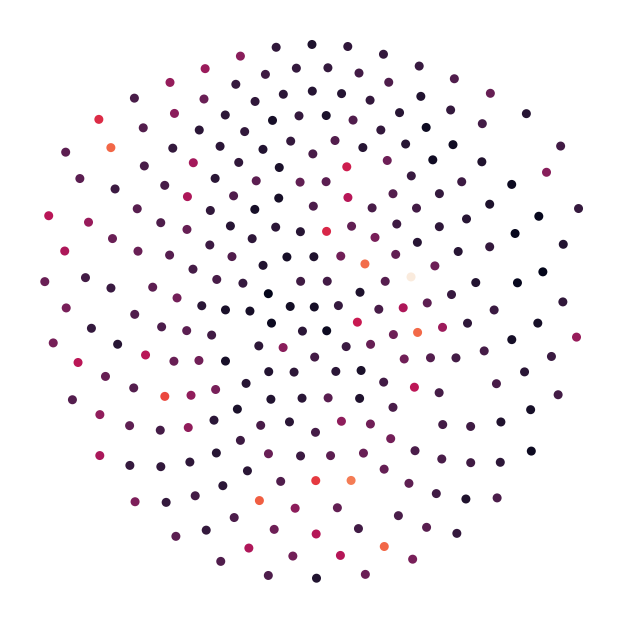

In [36]:
channel_weights = a.mean(dim=0)  # (C,)
x = loc[:, 0].cpu().numpy()
y = loc[:, 1].cpu().numpy()

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(x, y, c=channel_weights, cmap='rocket', s=20, alpha = 1)
plt.axis('equal')
plt.axis('off')
plt.show()


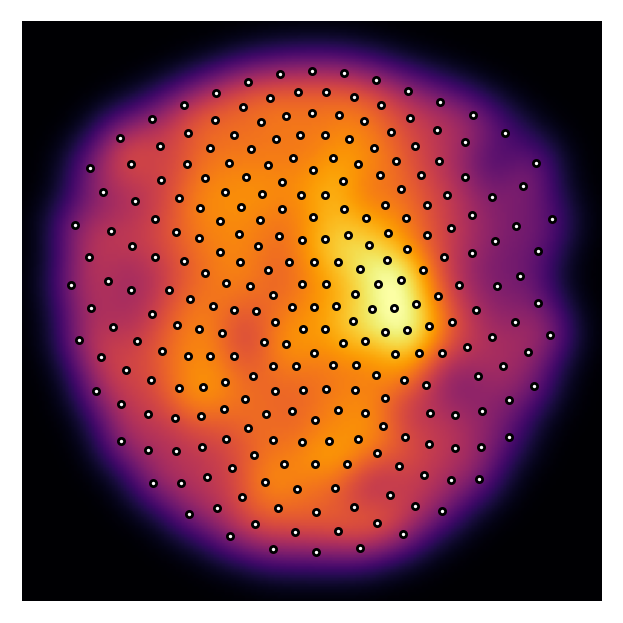

In [37]:
from sklearn.neighbors import KernelDensity
positions = np.vstack([x, y]).T

kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(positions, sample_weight=channel_weights)

pixs = 200

x_grid = np.linspace(np.min(x)-0.1, np.max(x)*1.1, pixs)
y_grid = np.linspace(np.min(y)-0.1, np.max(y)*1.1, pixs)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

log_dens = kde.score_samples(grid_points)
densities = np.exp(log_dens).reshape(x_grid.shape)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(densities, origin='lower', cmap='inferno')
sc_x = (x - (np.min(x)-0.1)) / (np.max(x)*1.1 - (np.min(x)-0.1)) * (pixs - 1)
sc_y = (y - (np.min(y)-0.1)) / (np.max(y)*1.1 - (np.min(y)-0.1)) * (pixs - 1)
ax.scatter(sc_x, sc_y, c='white', s=20, edgecolors='black', zorder=100)
plt.axis('off')
plt.axis('equal')
plt.show()
